# 전체적인 설명

**코드작성
- jupyter notebook

**접근방법
- 3d 이미지를 시각화 해보았을 때 틀어진 사진들이 생각보다 많았다. (수치적으로 통계내보지는 않았음)
- dataset 구조를 보면 숫자를 표현하고있는 좌표의 개수가 각각 다르다. (ex 21500, 17500...)
- 좌표의 개수 * 3 (x,y,z 값) 자체 학습은 다소 힘들어 보였다.
- 3d 이미지에서 숫자를 가장 잘 표현 할 수 있는 단면으로 잘라서 이미지로 저장 -> 2d이미지 분류로 접근하면 어떨까?
- 이미지 별로 단면을 자르는 함수를 제작하기 당장 어렵다.
- pca로 데이터 하나하나당 차원축소를 시도한다면 2d 이미지로 시각화 하였을 때 유의미한 결과를 얻을 수 있지 않을까?

- 기존에 pca만 시도했다면, 다양한 PCA기법들을 사용하여 데이터 전처리시도

**모델 요약
- train data : 50,000개, test data : 40,000개
- image shape은 50 * 50 에서 28 * 28로 줄여서 학습 (parameter 개수 줄이기위해)
- train data, test data 2d 이미지 저장 할 때 직접 h5 data에 하나하나 접근하여 imgae로 저장하는 형식으로 코딩
- CNN기반 다양한 모델 시도

**해결한 부분
<span style=''>train data, test data 2d 이미지 저장 할 때 out of memory 이슈가 자주 발생하여서 우선 준비한 30000개만 학습에 사용</span>
- h5 -> list -> image 순서가 아닌 h5 -> image 형식으로 접근하여 해결

<span style=''>- 추가적으로 학습 할 때 이미지가 올 곧게 서있지 않기 때문에 cv2로 rotate 0~180 45도 간격으로 데이터 하나당 5배로 증강
</span>
- 회전은 오히려 정확도에 부정확한 영향을 미칠 것이라 예상하여 증강하지 않음.


**앞으로 할 시도
- CNN모델 말고 VGG, Resnet과 같은 다양한 모델로 시도해보아도 좋겠다.
    - VGG, Resnet 너무 무거워서 오히려 정확도가 떨어지는 결과가 보여지긴함.
    - 경량화 시켜서 재시도 할 가치는 있어보임
- train data 30000개 말고 50000개 전체를 학습시키자

**실패 한 시도들
- 기억이 나는 것들 위주로 정리

1. LDA기법 활용하여 차원축소(보통 자연어처리에서 차원축소를 위해 많이 사용, 현 데이터셋에 적용하기에는 적절치 않아보인다.)
2. padding하여 좌표 자체를 활용하여 학습
3. TruncatedSVD 활용하여 유의미한 image 도출
4. from numba import jit을 활용한 연산속도 개선시도 -> plt에 적용되지 않아 오류발생
5. 이미지 저장하지 않고 array만 반환받아 traindata로 사용
6. 

In [23]:
#사용 모듈
import os
import time
import warnings
warnings.filterwarnings('ignore')

import math
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import Image

from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import h5py # .h5 파일을 읽기 위한 패키지
import cv2

from sklearn.decomposition import PCA
from sklearn.decomposition import IncrementalPCA
from sklearn.decomposition import KernelPCA #연산량이 많아 사용 불가
from sklearn.decomposition import SparsePCA
from sklearn.decomposition import NMF
from sklearn.decomposition import FastICA
from scipy import sparse

In [24]:
#데이터셋 준비
train_df = pd.read_csv('./dataset/train.csv')

train_all = h5py.File('./dataset/train.h5', 'r')
# test_all = h5py.File('./dataset/test.h5', 'r')

In [3]:
np.array([train_df['label'][12745]])

array([2], dtype=int64)

#### 데이터셋의 좌표 길이가 전부 다름

target값이 같아도 표현되는 길이가 전부 다름을 알 수 있음.

In [104]:
for i in range(10):
    print("{}번째 - len : {}, target : {}".format(i, len(np.array(train_all[str(i)])), train_df['label'][i]))

0번째 - len : 25700, target : 5
1번째 - len : 26200, target : 0
2번째 - len : 21000, target : 4
3번째 - len : 15000, target : 1
4번째 - len : 21500, target : 9
5번째 - len : 26800, target : 2
6번째 - len : 13350, target : 1
7번째 - len : 27400, target : 3
8번째 - len : 10900, target : 1
9번째 - len : 22100, target : 4


### 다양한 PCA 기법으로 3D image -> 2D image로 표현

1. PCA
2. Incremental PCA
3. Sparse PCA 
4. fast ICA


- 결과적으로 Sparse PCA가 가장 가시적으로 유의미하게 2D image로 표현해줌


* 세부설명

- 좌표로 구성되어있는 3D image를 데이터 한개 한개 당 PCA를 적용하여 2D로 표현
- 표현결과 Sparse PCA가 가장 잘 표현해줌
- (2,5), (6,9) 분류도 가장 잘해주고 있다.

#### 1. PCA

  0%|          | 0/500 [00:00<?, ?it/s]

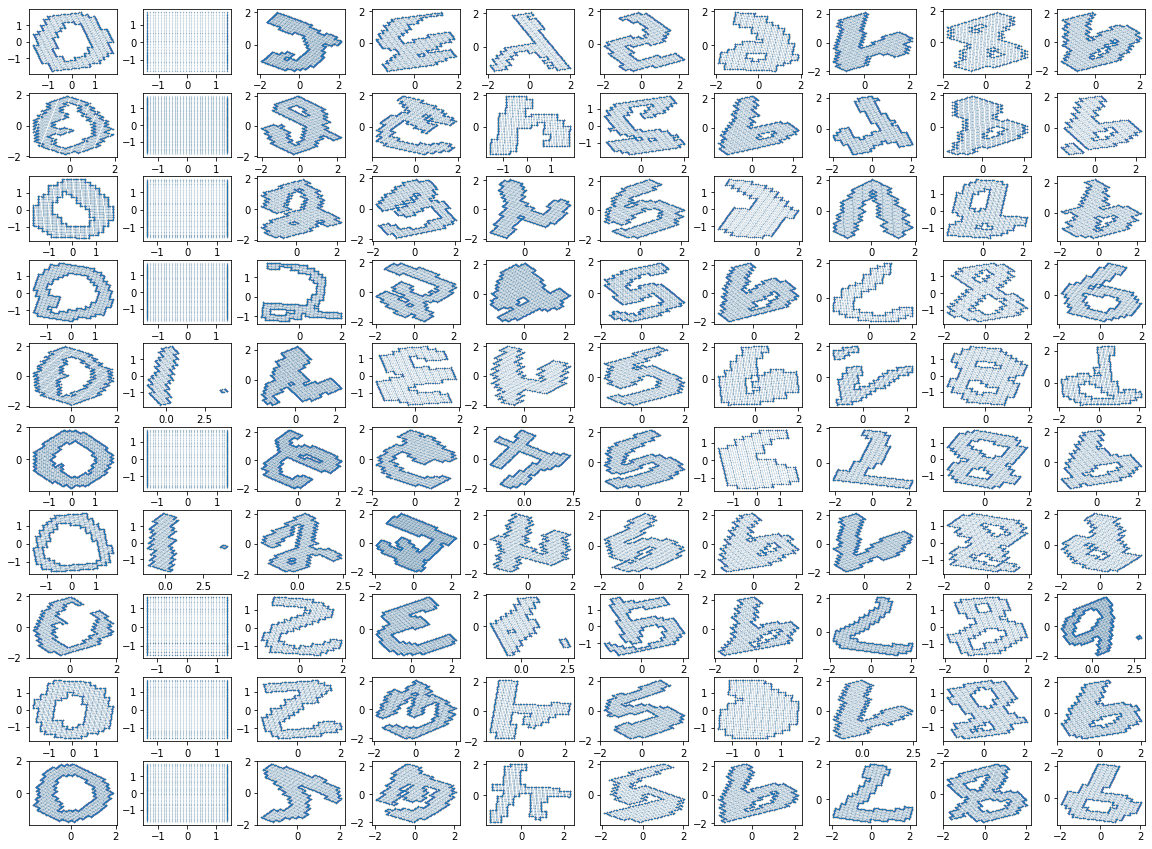

In [72]:
#train, test data 시각화준비과정 - PCA

f, axes = plt.subplots(10, 10)

# 격자 크기 설정
f.set_size_inches((20, 15))

# 격자 여백 설정
plt.subplots_adjust(wspace = 0.3, hspace = 0.3)

numcount = [0 for _ in range(10)]

for i in tqdm(range(1000,1500)):
    now_target = train_df['label'][i]
    testdata = np.array(train_all[str(i)])
    
    #3차원 -> 2차원으로 축소
    pca = PCA(n_components=2, whiten = True, svd_solver='arpack', 
              tol=5.0, iterated_power='auto', n_oversamples=50, 
              power_iteration_normalizer='auto', random_state=None)

    df_pca = pca.fit_transform(testdata)

    x = df_pca[:, 1]
    y = df_pca[:, 0]

    #산점도의 점크기 -> s=1로 하면 사진이 너무 두꺼워짐
    if numcount[now_target]<10:
        axes[numcount[now_target], now_target].scatter(x, y, s=0.05, alpha=0.1)
        numcount[now_target]+=1
        
plt.show()
        
           

#### 2. IncrementalPCA

  0%|          | 0/200 [00:00<?, ?it/s]

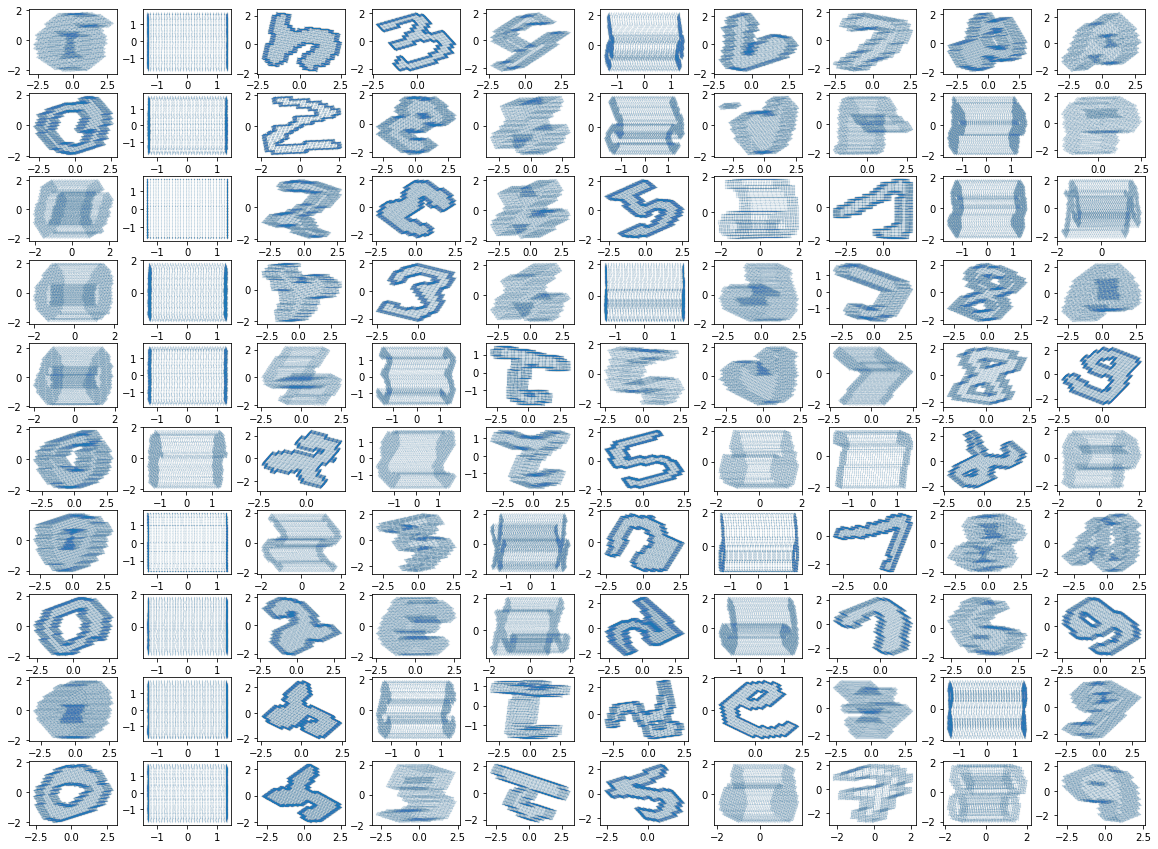

In [22]:
#train, test data 시각화준비과정 - IncrementalPCA

f, axes = plt.subplots(10, 10)

# 격자 크기 설정
f.set_size_inches((20, 15))

# 격자 여백 설정
plt.subplots_adjust(wspace = 0.3, hspace = 0.3)

numcount = [0 for _ in range(10)]

for i in tqdm(range(1300,1500)):
    now_target = train_df['label'][i]
    testdata = np.array(train_all[str(i)])

    #3차원 -> 2차원으로 축소
    transformer = IncrementalPCA(n_components=2, batch_size=100, whiten = True)
    tsetdata = sparse.csr_matrix(testdata)

    df_pca = transformer.fit_transform(testdata)

    x = df_pca[:, 1]
    y = df_pca[:, 0]


    #산점도의 점크기 -> s=1로 하면 사진이 너무 두꺼워짐
    if numcount[now_target]<10:
        axes[numcount[now_target], now_target].scatter(x, y, s=0.05, alpha=0.1)
        numcount[now_target]+=1
        
plt.show()
        
           

#### 3-1. Sparse PCA (method - lars)

  0%|          | 0/300 [00:00<?, ?it/s]

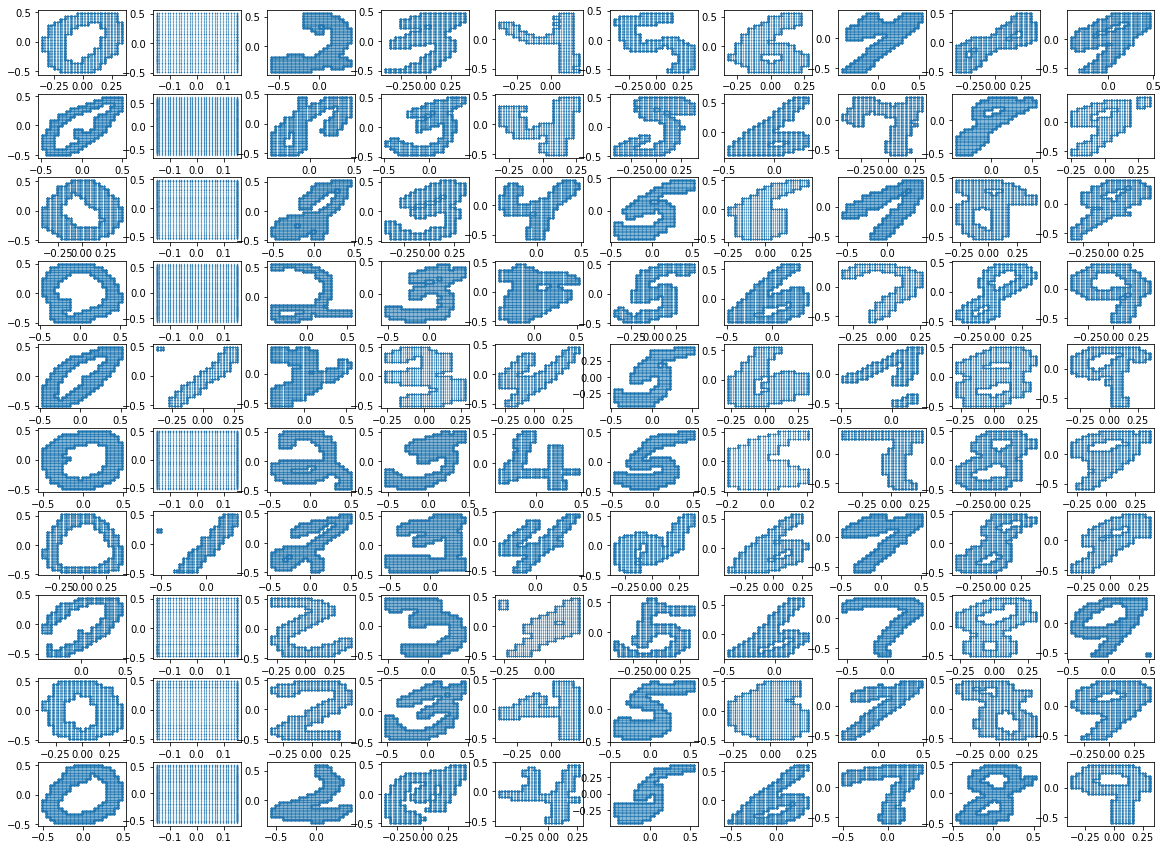

In [18]:
#train, test data 시각화준비과정 - Sparse PCA

f, axes = plt.subplots(10, 10)

# 격자 크기 설정
f.set_size_inches((20, 15))

# 격자 여백 설정
plt.subplots_adjust(wspace = 0.3, hspace = 0.3)

numcount = [0 for _ in range(10)]

for i in tqdm(range(1000,1300)):
    now_target = train_df['label'][i]
    testdata = np.array(train_all[str(i)])
    
    #3차원 -> 2차원으로 축소
    transformer = SparsePCA(n_components=2, alpha = 5, n_jobs = -1, )
    df_pca = transformer.fit_transform(testdata)

    x = df_pca[:, 1]
    y = df_pca[:, 0]


    #산점도의 점크기 -> s=1로 하면 사진이 너무 두꺼워짐
    if numcount[now_target]<10:
        axes[numcount[now_target], now_target].scatter(x, y, s=0.05, alpha=0.4)
        numcount[now_target]+=1
        
plt.show()
        
           

#### 3-2. Sparse PCA (method - cd)

  0%|          | 0/500 [00:00<?, ?it/s]

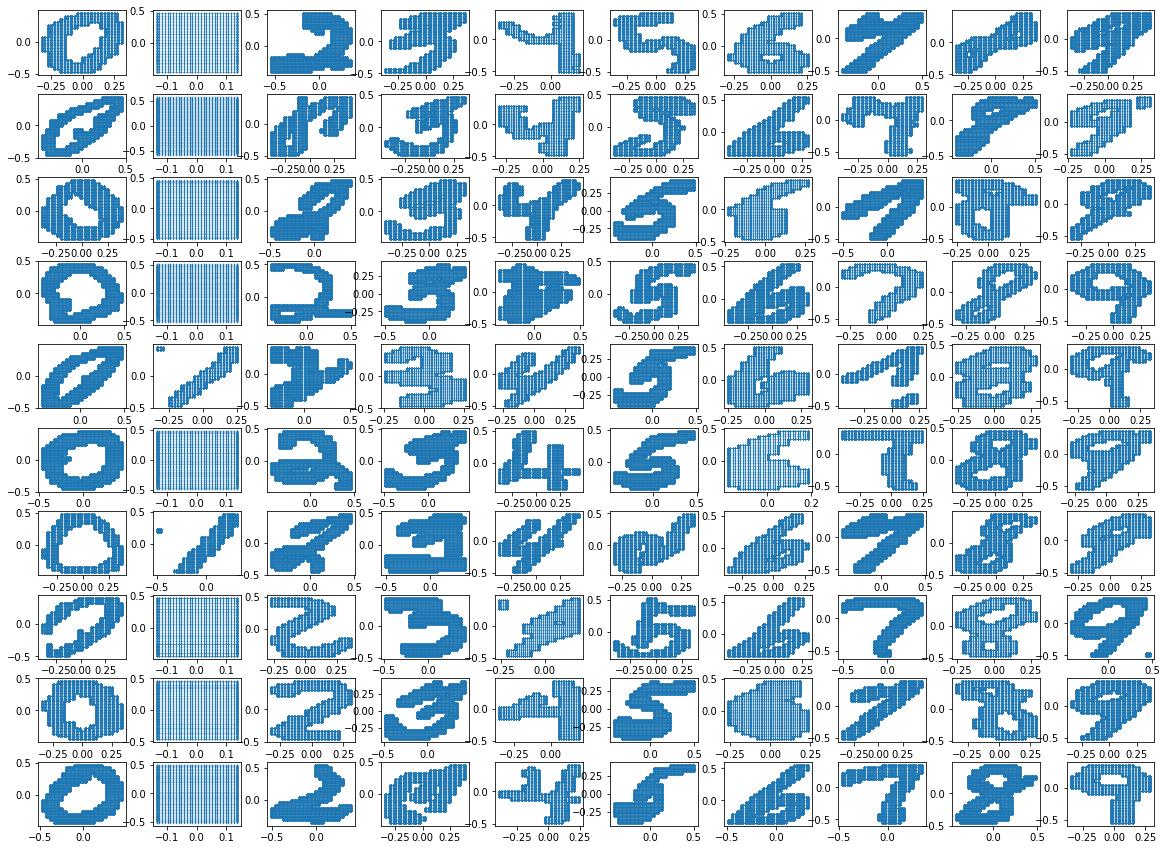

In [17]:
#train, test data 시각화준비과정 - Sparse PCA - method cd

count = 0
failcount = 0 

f, axes = plt.subplots(10, 10)

# 격자 크기 설정
f.set_size_inches((20, 15))

# 격자 여백 설정
plt.subplots_adjust(wspace = 0.3, hspace = 0.3)

numcount = [0 for _ in range(10)]

for i in tqdm(range(1000,1500)):
    now_target = train_df['label'][i]
    testdata = np.array(train_all[str(i)])

    #3차원 -> 2차원으로 축소
    transformer = SparsePCA(n_components=2, method ='cd', ridge_alpha = 0.1, n_jobs = -1, max_iter = 2000, tol = 1e-09)
    df_pca = transformer.fit_transform(testdata)

    x = df_pca[:, 1]
    y = df_pca[:, 0]

    #산점도의 점크기 -> s=1로 하면 사진이 너무 두꺼워짐
    if numcount[now_target]<10:
        axes[numcount[now_target], now_target].scatter(x, y, s=0.05, alpha=1)
        numcount[now_target]+=1
    
    if numcount.count(10) == 10:
        break
        
plt.show()
        
           

#### 4. fast ICA

  0%|          | 0/500 [00:00<?, ?it/s]

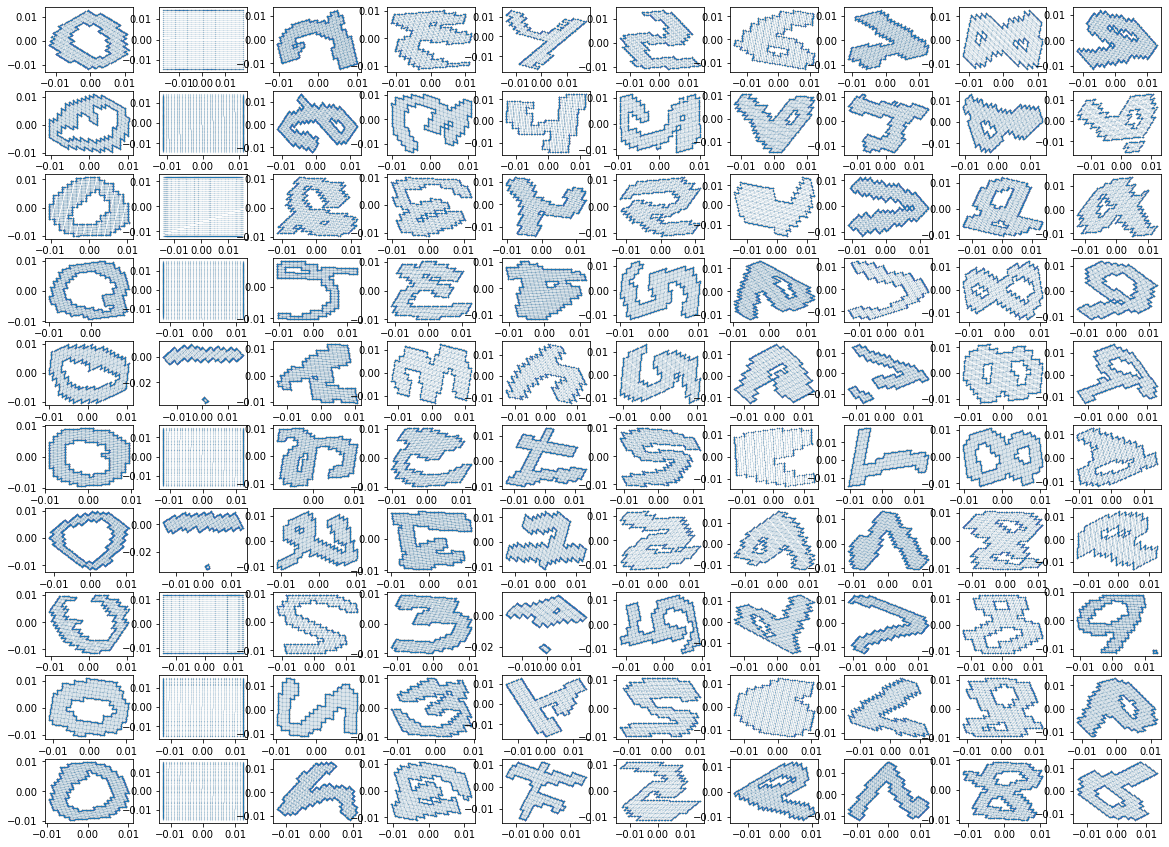

In [27]:
#train, test data 시각화준비과정 - fastICA

count = 0
failcount = 0 

f, axes = plt.subplots(10, 10)

# 격자 크기 설정
f.set_size_inches((20, 15))

# 격자 여백 설정
plt.subplots_adjust(wspace = 0.3, hspace = 0.3)

numcount = [0 for _ in range(10)]

for i in tqdm(range(1000,1500)):
    now_target = train_df['label'][i]
    testdata = np.array(train_all[str(i)])

    #3차원 -> 2차원으로 축소
    

    ica = FastICA(n_components=2)
    df_pca = ica.fit_transform(testdata)
    
    x = df_pca[:, 1]
    y = df_pca[:, 0]

    #산점도의 점크기 -> s=1로 하면 사진이 너무 두꺼워짐
    if numcount[now_target]<10:
        axes[numcount[now_target], now_target].scatter(x, y, s=0.05, alpha=0.1)
        numcount[now_target]+=1
        
plt.show()

#### 데이터셋 준비

- Sparse PCA - method lars : 기법이 가장 2D 이미지로 잘 바꿔주었다.
- method는 결과에서는 큰 차이가 없었고
- 실험적으로 lars가 cd에 비해 실험적인 연산속도가 빨랐기 때문에 method는 lars사용
- train, test 전부 3D-> 2D 이미지로 변환
- scatter params => alpha = 1, s = 0.05
- image size는 50x50으로 저장

** method{‘lars’, ‘cd’}, default=’lars’
Method to be used for optimization. 
lars: uses the least angle regression method to solve the lasso problem (linear_model.lars_path) 
cd: uses the coordinate descent method to compute the Lasso solution (linear_model.Lasso). 
Lars will be faster if the estimated components are sparse.

##### train data set 준비과정

- 총 50000개 데이터 이미지파일로 변환 후 저장(image size : 50 * 50)
- 이미지 하나하나 PCA과정 거친 후 img file로 저장하는 방식이다보니 시간이 꽤 걸렸다. (어림잡아 8시간.. 시간단축 방법에 대한 조언 부탁드립니다.)
- 아직 연산 처리속도 개선에 대한 경험이 많지 않아 효과적으로 준비과정을 구성하는 법이 미숙한것 같다.
- 50000개를 한번에 처리하지 않고 10000단위씩 끊어 여러번 준비하는 형식으로 구문작성 해보았다.


#### 개선 idea(미적용)

- 1이 정사각형모양, /모양 두가지로 나뉘는데 Class를 따로 target을 총 11개로 예측시키고 하나로 병합하는 과정으롸 접근해봐도 좋아보임.

- 분류가 애매해보이는 이미지 데이터에 따로 labeling 진행 후 데이터 증강 후 학습시키는것이 좋아보임.

In [6]:
#train data 개수 50000개


for i in tqdm(range(10000, 10010)):
    testdata = np.array(train_all[str(i)])

    transformer = SparsePCA(n_components=2, method ='lars')
    df_pca = transformer.fit_transform(testdata)

    fig = plt.figure(figsize=(1,1))

    x = df_pca[:, 1]
    y = df_pca[:, 0]

    plt.axis('off')
    plt.scatter(x, y, s = 0.05, alpha = 1)
    plt.savefig('./dataset/Sparseimage/train/train_image{:0>5}.png'.format(i), dpi=50)
    plt.close(fig)        

  0%|          | 0/10 [00:00<?, ?it/s]

In [3]:
#데이터셋 준비
train_df = 0

train_all = 0
test_all = h5py.File('./dataset/test.h5', 'r')

(72, 72, 4)


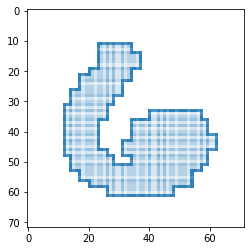

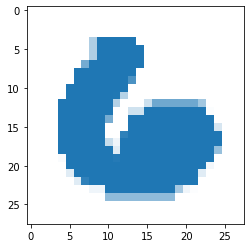

In [25]:
import numpy as np 
import matplotlib.pyplot as plt 

def figure_to_array(fig):
    """
    plt.figure를 RGBA로 변환(layer가 4개)
    shape: height, width, layer
    """
    fig.canvas.draw()
    return np.array(fig.canvas.renderer._renderer)

fig = plt.figure(figsize=(1,1))

x = df_pca[:, 1]
y = df_pca[:, 0]

plt.axis('off')
plt.scatter(x, y, s = 0.05, alpha = 0.1)
#plt.margins(0, 0, tight=False)
plt.close() # 쥬피터 노트북에 그림이 자동으로 뜨는 것을 막으려고 사용. 

f_arr = figure_to_array(fig)
print(f_arr.shape) # 이 RGBA로 변환됨. 
plt.figure()
plt.imshow(f_arr[:, :, :])

arr = np.delete(f_arr, 3 , axis = 2)
arr.shape

rgba = cv2.cvtColor(f_arr, cv2.COLOR_RGBA2RGB)
rgba = cv2.resize(rgba, (28,28))
plt.figure()
plt.imshow(rgba[:, :, :])
# cv2.imshow("Moon", rgba)
# cv2.waitKey()
# cv2.destroyAllWindows()

In [4]:
#test data 40000

j=19000
while j < 40000:
    print("{}구간 진행중...".format(j))
    for i in tqdm(range(j, j+7000)):
#         testdata = np.array(train_all[str(i)])

        transformer = SparsePCA(n_components=2, method ='lars')
        df_pca = transformer.fit_transform(np.array(test_all[str(i+50000)]))

        fig = plt.figure(figsize=(1,1))

#         x = df_pca[:, 1]
#         y = df_pca[:, 0]

        plt.axis('off')
        plt.scatter(df_pca[:, 1], df_pca[:, 0], s = 0.05, alpha = 1)
        plt.savefig('./dataset/Sparseimage/test/test_image{:0>5}.png'.format(i), dpi=50)
        plt.close(fig)
        
    j += 6000

19000구간 진행중...


  0%|          | 0/7000 [00:00<?, ?it/s]

25000구간 진행중...


  0%|          | 0/7000 [00:00<?, ?it/s]

31000구간 진행중...


  0%|          | 0/7000 [00:00<?, ?it/s]

37000구간 진행중...


  0%|          | 0/7000 [00:00<?, ?it/s]

KeyError: "Unable to open object (object '90000' doesn't exist)"

In [3]:
#test data 개수 40000개

for i in tqdm(range(3654, 4000)):
    testdata = np.array(test_all[str(i+50000)])

    transformer = SparsePCA(n_components=2, method ='lars')
    df_pca = transformer.fit_transform(testdata)

    fig = plt.figure(figsize=(1,1))

    x = df_pca[:, 0]
    y = df_pca[:, 1]

    plt.axis('off')
    plt.scatter(x, y, s = 0.05, alpha = 1)
    
    plt.savefig('./dataset/Sparseimage/test/test_image{:0>5}.png'.format(i), dpi=50)
    plt.close(fig)

  0%|          | 0/346 [00:00<?, ?it/s]

In [5]:
#나중에 지움
train_df = pd.read_csv('./dataset/train.csv')

train_all = h5py.File('./dataset/train.h5', 'r')
test_all = 0

**준비 된 train, test image 결과 시각화

- 네모 모양으로 꽉차있는 사진들은 전부 1
- 나머지 숫자들도 어느정도 유의미하게 2d로 변환된것을 확인

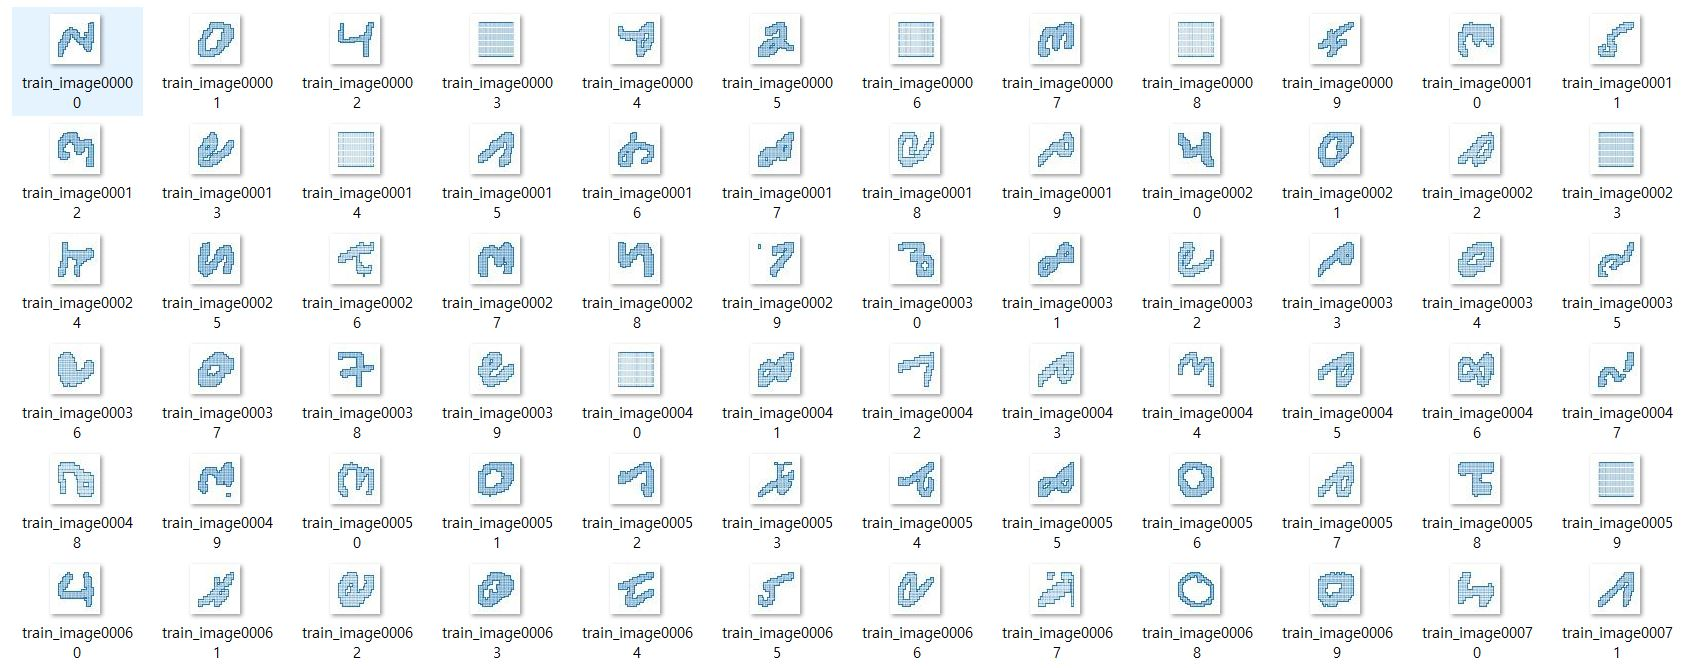

In [6]:
#Sparse PCA 사용 한 dataset
Image('./dataset/pcaimage/refer002.jpg')

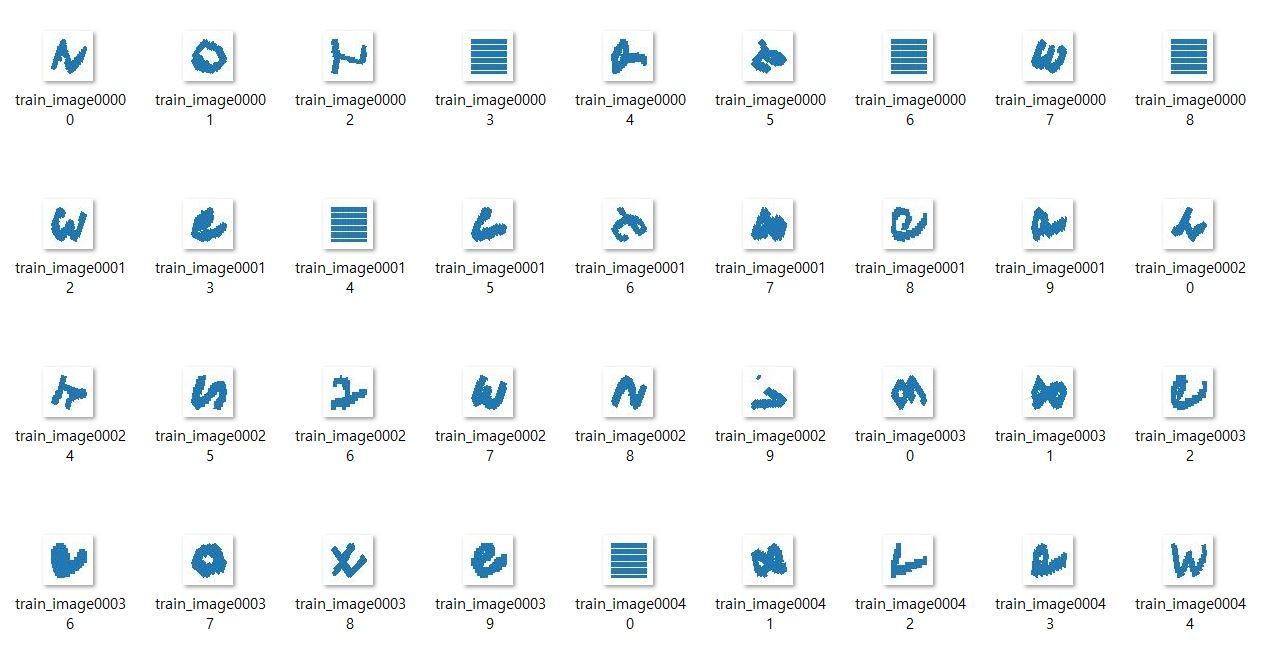

In [4]:
#기존 pca로 변환한 이미지 - (비교용)
Image('./dataset/pcaimage/refer001.jpg')

**모델 설계 부분

In [26]:
# #이미지 회전 함수 정의
# def RotateImage(img, angle, scale=1):
#     if img.ndim > 2:
#         height, width, channel = img.shape
#     else:
#         height, width = img.shape
 
#     matrix = cv2.getRotationMatrix2D((width / 2, height / 2), angle, scale)
#     result = cv2.warpAffine(img, matrix, (width, height))
 
#     return result


#학습에 사용할 train data 길이
train_length = 50000

#학습에 사용할 shape 정의
sp = 32 #shape

def RotateImage(img, angle, scale=1):
    if img.ndim > 2:
        height, width, channel = img.shape
    else:
        height, width = img.shape
 
    matrix = cv2.getRotationMatrix2D((width / 2, height / 2), angle, scale)
    result = cv2.warpAffine(img, matrix, (width, height))
 
    return result


#sharpening mask
sharpening_mask1 = np.array([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]])
sharpening_mask2 = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
smoothing_mask = np.array([[1 / 16, 1 / 8, 1 / 16], [1 / 8, 1 / 4, 1 / 8], [1 / 16, 1 / 8, 1 / 16]])

pca_data = []
for j in tqdm(range(train_length)):
    img = cv2.imread("./dataset/Sparseimage/train/train_image{:0>5}.png".format(j), cv2.IMREAD_GRAYSCALE)
    img2 = cv2.imread("./dataset/pcaimage/train_image{:0>5}.jpg".format(j), cv2.IMREAD_GRAYSCALE)

    img = cv2.resize(img, (sp, sp))
    img2 = cv2.resize(img2, (sp, sp))
    
    merged = np.hstack((img, img2))

    
    pca_data.append(merged)  
        


# pca_data = []
# for j in tqdm(range(train_length)):
#     img = cv2.imread("./dataset/Sparseimage/train/train_image{:0>5}.png".format(j), cv2.IMREAD_GRAYSCALE)
    
# #     for angle in range(0, 181, 45):
# #     for angle in range(90, 91):
# #         rad = 20 * math.pi / 180	# 각도 설정
# #         image = RotateImage(img, angle-90, 1)
#     img = cv2.resize(img, (200, 200))

#     # 구조화 요소 커널, 사각형 (3x3) 생성 ---①
#     k = cv2.getStructuringElement(cv2.MORPH_RECT, (11,11))
#     k2 = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))

#     # 팽창 연산 적용 ---②
#     dst = cv2.dilate(img, k)
#     dst = cv2.dilate(dst, k2)

#     #팽창 후 가우시안
#     gau = cv2.GaussianBlur(dst, (0, 0), 2)

#     #가우시안 후 샤프닝
#     sha1 = cv2.filter2D(gau, -1, sharpening_mask1)
#     # sharpening_out2 = cv2.filter2D(gray, -1, sharpening_mask2)

#     img = cv2.resize(sha1, (sp, sp))
#     pca_data.append(img)  
        
        
tg = []        
for i in range(train_length):
    for _ in range(1):
        tg.append(train_df['label'][i])

target = np.array(tg)

  0%|          | 0/50000 [00:00<?, ?it/s]

**총 데이터 length, target length확인

In [27]:
print(len(pca_data))
print(len(target))

50000
50000


In [28]:
pca_data[1].shape

(32, 64)

**prepare data & model summary

In [29]:
#try cnn 2-2
data = np.array(pca_data)
# train_test_split
x_train, x_test, y_train, y_test = train_test_split(data, target, test_size=0.1, shuffle=True, stratify=target, random_state=34)
# x_test, x_valid, y_test, y_valid = train_test_split(x_valid, y_valid, test_size = 0.5, shuffle = True, stratify=y_valid, random_state=34)

# 각종 파라메터의 영향을 보기 위해 랜덤값 고정
tf.random.set_seed(1234)

# Normalizing data
x_train, x_test = x_train / 255.0, x_test / 255.0

# (50000, sp, sp) => (50000, sp, sp, 1)로 reshape
x_train = x_train.reshape(-1, sp, sp*2, 1)
x_test = x_test.reshape(-1, sp, sp*2, 1)

# One-hot 인코딩
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)


# cnn modeling

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(kernel_size=(3,3), filters=64, input_shape=(sp,sp*2,1), padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=(3,3), filters=64, padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2)),

    tf.keras.layers.Conv2D(kernel_size=(3,3), filters=128, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=(3,3), filters=256, padding='valid', activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=512, activation='relu'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(units=256, activation='relu'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(units=10, activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 32, 64, 64)        640       
                                                                 
 conv2d_5 (Conv2D)           (None, 32, 64, 64)        36928     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 16, 32, 64)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 16, 32, 128)       73856     
                                                                 
 conv2d_7 (Conv2D)           (None, 14, 30, 256)       295168    
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 7, 15, 256)       0         
 2D)                                                  

In [30]:
target[:10]

array([5, 0, 4, 1, 9, 2, 1, 3, 1, 4], dtype=int64)

In [9]:
#try cnn 2-2
data = np.array(pca_data)
# train_test_split
x_train, x_test, y_train, y_test = train_test_split(data, target, test_size=0.1, shuffle=True, stratify=target, random_state=34)
# x_test, x_valid, y_test, y_valid = train_test_split(x_valid, y_valid, test_size = 0.5, shuffle = True, stratify=y_valid, random_state=34)

# 각종 파라메터의 영향을 보기 위해 랜덤값 고정
tf.random.set_seed(1234)

# Normalizing data
x_train, x_test = x_train / 255.0, x_test / 255.0

# (50000, sp, sp) => (50000, sp, sp, 1)로 reshape
x_train = x_train.reshape(-1, sp, sp, 1)
x_test = x_test.reshape(-1, sp, sp, 1)

# One-hot 인코딩
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)


model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, kernel_size=(5, 5), strides=(1, 1),
                  padding='same', activation='relu', input_shape=(sp, sp, 1)),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
    tf.keras.layers.Conv2D(64, kernel_size=(2, 2), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1000, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])
model.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 32, 32, 32)        832       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 64)        8256      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 8, 8, 64)         0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 8, 8, 64)          0         
                                                                 
 flatten_1 (Flatten)         (None, 4096)             

**model fit & best model save

In [31]:
#모델 최적화
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

modelpath = './dataset/model/imageMerged_CNN_happy001.h5'
checkpointer = ModelCheckpoint(filepath = modelpath, monitor = 'val_loss', verbose = 1, save_best_only = True)
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 5)

#모델링 실행
history = model.fit(x_train, y_train, validation_split=0.25, epochs = 30, batch_size = 128, verbose=1, 
                    callbacks = [early_stopping_callback, checkpointer])


#테스트 정확도
print('\n Test Accuracy: {}'.format(round(model.evaluate(x_test, y_test)[1], 3)))

# 검증셋, 학습셋 오차 저장
y_vloss = history.history['val_loss']
y_loss = history.history['loss']

# 그래프로 표현
x_len = np.arange(len(y_loss))
plt.plot(x_len, y_vloss, marker='.', c='red', label='Testset_loss')
plt.plot(x_len, y_loss, marker='.', c='blue', label='Trainset_loss')


# 그래프에 그리드 부여 및 레이블 표시
plt.legend(loc = 'upper right')
# plt.gird()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

Epoch 1/30
264/264 [==============================] - ETA: 0s - loss: 0.4620 - accuracy: 0.8520
Epoch 1: val_loss improved from inf to 0.14703, saving model to ./dataset/model\imageMerged_CNN_happy001.h5
264/264 [==============================] - 463s 2s/step - loss: 0.4620 - accuracy: 0.8520 - val_loss: 0.1470 - val_accuracy: 0.9567
Epoch 2/30
264/264 [==============================] - ETA: 0s - loss: 0.1387 - accuracy: 0.9606
Epoch 2: val_loss improved from 0.14703 to 0.10937, saving model to ./dataset/model\imageMerged_CNN_happy001.h5
264/264 [==============================] - 469s 2s/step - loss: 0.1387 - accuracy: 0.9606 - val_loss: 0.1094 - val_accuracy: 0.9680
Epoch 3/30
264/264 [==============================] - ETA: 0s - loss: 0.0930 - accuracy: 0.9740
Epoch 3: val_loss improved from 0.10937 to 0.10548, saving model to ./dataset/model\imageMerged_CNN_happy001.h5
264/264 [==============================] - 473s 2s/step - loss: 0.0930 - accuracy: 0.9740 - val_loss: 0.1055 - val_a

KeyboardInterrupt: 

In [67]:
x_final = data / 255.0
x_final = x_final.reshape(-1, sp, sp, 1)
y_final = tf.keras.utils.to_categorical(target, 10)

final_model = model.fit(x_final, y_final, epochs = 4, batch_size = 128, verbose = 1)

Epoch 1/4
391/391 [==============================] - 350s 894ms/step - loss: 0.5621 - accuracy: 0.8181
Epoch 2/4
391/391 [==============================] - 334s 853ms/step - loss: 0.1800 - accuracy: 0.9509
Epoch 3/4
391/391 [==============================] - 349s 893ms/step - loss: 0.1356 - accuracy: 0.9636
Epoch 4/4
391/391 [==============================] - 357s 913ms/step - loss: 0.1131 - accuracy: 0.9687


In [86]:
model.predict(x_final[4].reshape(-1,32,32,1))

1/1 [==============================] - 0s 23ms/step


array([[3.5920482e-06, 9.0165450e-08, 1.0344809e-05, 1.1952458e-05,
        4.2750957e-04, 1.4758477e-06, 2.8294070e-07, 1.6075892e-05,
        7.6281332e-04, 9.9876583e-01]], dtype=float32)

In [82]:
x_final.shape

(50000, 32, 32, 1)

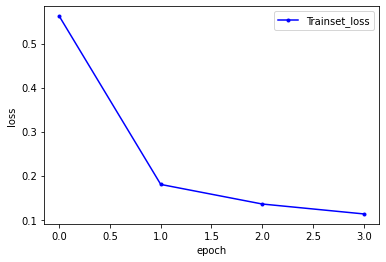

In [69]:
# 검증셋, 학습셋 오차 저장
# y_vloss = final_model.history['val_loss']
y_loss = final_model.history['loss']

# 그래프로 표현
x_len = np.arange(len(y_loss))
# plt.plot(x_len, y_vloss, marker='.', c='red', label='Testset_loss')
plt.plot(x_len, y_loss, marker='.', c='blue', label='Trainset_loss')


# 그래프에 그리드 부여 및 레이블 표시
plt.legend(loc = 'upper right')
# plt.gird()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

### testdata 예측 및 제출

In [94]:
# #0901 제작 모델, CNN기반 2번째 모델 val_acc 0.91
# model = tf.keras.models.load_model('./dataset/model/image_CNN02.h5')

# #0902 제작 모델, VGG기반 1번째 모델 val_acc -
# model = tf.keras.models.load_model('./dataset/model/image_VGG01.h5')

#0902 제작 모델, CNN기반 50000개 데이터 사용 회전 x val_acc 0.91
# model = tf.keras.models.load_model('./dataset/model/image_CNN03.h5')

#0903 제작 모델, CNN기반 200000개 데이터 회전 o  val_acc 0.91
#model = tf.keras.models.load_model('./dataset/model/image_CNN04.h5')

#0907 제작 모델, CNN기반 50000개 데이터(use Sparse PCA) 학습, val_acc 0.97 제출 성적나쁨
# model = tf.keras.models.load_model('./dataset/model/imageSparse_CNN01.h5')

#0908 제작 모델, CNN기반 회전된 250000개 데이터(use Sparse PCA) 학습, val_acc 0.97
# model = tf.keras.models.load_model('./dataset/model/imageSparse_CNN02.h5')

#0909 제작 모델, CNN기반 침식 -> 가우시안 블러링 -> 샤프닝으로 이미지 처리데이터 50000개사용, val_acc 0.98 왜성적이 나쁘지..
# model = tf.keras.models.load_model('./dataset/model/usealldata_sparse_CNN001.h5')

#0909 제작 모델 , CNN기반 침식 -> 가우시안 블러링 -> 샤프닝으로 이미지 처리데이터 50000개사용, val_acc 0.98 왜성적이 나쁘지..
# model = tf.keras.models.load_model('./dataset/model/imageSparse_CNN03.h5')

#0909 제작 모델, CNN기반 침식 데이터.. pcaimage사용 val_acc 0.91
# model = tf.keras.models.load_model('./dataset/model/imagePCA_CNN02.h5')

#0910 제작 모델, CNN기반 침식 데이터.. sparseimage사용 val_acc 0.97
# model = tf.keras.models.load_model('./dataset/model/imageSPARSE_CNN_happy001.h5')


In [114]:
###### 나중에 삭제
train_df = 0

train_all = 0
# test_all = h5py.File('./dataset/test.h5', 'r')

In [13]:
sub_df = pd.read_csv('./dataset/sample_submission.csv')

In [14]:
##### 나중에 삭제
pca_data = 0
data = 0

In [32]:
sp = 32
test_length = 40000

test_data = []
for j in tqdm(range(test_length)):
    
    img = cv2.imread("./dataset/Sparseimage/test/test_image{:0>5}.png".format(j), cv2.IMREAD_GRAYSCALE)
    img2 = cv2.imread("./dataset/testimage/test_image{:0>5}.jpg".format(j), cv2.IMREAD_GRAYSCALE)

    img = cv2.resize(img, (sp, sp))
    img2 = cv2.resize(img2, (sp, sp))
    
    merged = np.hstack((img, img2))

    
    test_data.append(merged)     
######################################    
#     img = cv2.imread("./dataset/Sparseimage/test/test_image{:0>5}.png".format(j), cv2.IMREAD_GRAYSCALE)
#     img = cv2.resize(img, (200, 200))

#     # 구조화 요소 커널, 사각형 (3x3) 생성 ---①
#     k = cv2.getStructuringElement(cv2.MORPH_RECT, (11,11))
#     k2 = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))

#     # 팽창 연산 적용 ---②
#     dst = cv2.dilate(img, k)
#     dst = cv2.dilate(dst, k2)

#     #팽창 후 가우시안
#     gau = cv2.GaussianBlur(dst, (0, 0), 2)

#     #가우시안 후 샤프닝
#     sha1 = cv2.filter2D(gau, -1, sharpening_mask1)
#     # sharpening_out2 = cv2.filter2D(gray, -1, sharpening_mask2)

#     image = cv2.resize(sha1, (sp, sp))
#     test_data.append(image)

  0%|          | 0/40000 [00:00<?, ?it/s]

In [35]:
test = np.array(test_data) / 255.0
test = test.reshape(-1, sp, sp*2, 1)

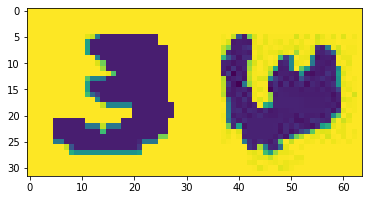

In [94]:
plt.imshow(data[10])

In [36]:
answer1 = model.predict(test[:10000])
answer2 = model.predict(test[10000:20000])
answer3 = model.predict(test[20000:30000])
answer4 = model.predict(test[30000:40000])

313/313 [==============================] - 39s 125ms/step


In [96]:
sub_dff = sub_df.copy()

In [37]:
answer = np.concatenate([answer1, answer2, answer3, answer4])

sub_answer = []

for i in tqdm(answer):
    sub_answer.append(np.argmax(i))
    
sub_df['label'] = sub_answer    

  0%|          | 0/40000 [00:00<?, ?it/s]

In [45]:
sub_df2 = pd.read_csv('./submission/image3d_useCNN03_try002.csv')
sub_df2.head(20)

ID  label
0   50000      7
1   50001      4
2   50002      2
3   50003      4
4   50004      9
5   50005      9
6   50006      0
7   50007      8
8   50008      4
9   50009      9
10  50010      4
11  50011      4
12  50012      1
13  50013      4
14  50014      7
15  50015      0
16  50016      4
17  50017      6
18  50018      7
19  50019      1

In [57]:
i = -1

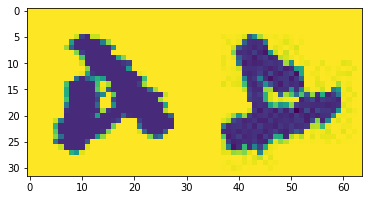

In [69]:
i+=1
plt.imshow(test[i])

In [38]:
sub_df.head(20)

ID  label
0   50000      2
1   50001      2
2   50002      2
3   50003      4
4   50004      9
5   50005      9
6   50006      0
7   50007      8
8   50008      4
9   50009      5
10  50010      4
11  50011      2
12  50012      1
13  50013      4
14  50014      7
15  50015      0
16  50016      4
17  50017      9
18  50018      5
19  50019      8

In [92]:
sub_df.head(20)

ID  label
0   50000      6
1   50001      6
2   50002      2
3   50003      4
4   50004      9
5   50005      9
6   50006      0
7   50007      2
8   50008      4
9   50009      8
10  50010      6
11  50011      2
12  50012      8
13  50013      4
14  50014      7
15  50015      0
16  50016      4
17  50017      9
18  50018      6
19  50019      8

In [122]:
sub_dff.head(20)

ID  label
0   50000      7
1   50001      4
2   50002      2
3   50003      4
4   50004      9
5   50005      9
6   50006      0
7   50007      8
8   50008      4
9   50009      5
10  50010      7
11  50011      7
12  50012      1
13  50013      4
14  50014      7
15  50015      0
16  50016      4
17  50017      9
18  50018      6
19  50019      1

In [70]:
sub_df.to_csv('./submission/happy0912.csv', index = False)


##007부터 기록
#007 -> 

In [26]:
print('Done!!')

Done!!


In [47]:
#2,5 6,9만 이 모델로 분류해보기
sub_df = pd.read_csv('./submission/image3d_useSparseCNN02_try005.csv')
sub_df2 = pd.read_csv('./submission/image3d_useCNN03_try002.csv')

In [84]:
s, e = 50,65
sub_df['label2'] = sub_df2['label']
se = 70

In [68]:

print(sub_df2[30:50])

       ID  label
30  50030      6
31  50031      5
32  50032      7
33  50033      1
34  50034      6
35  50035      2
36  50036      9
37  50037      7
38  50038      4
39  50039      3
40  50040      0
41  50041      3
42  50042      8
43  50043      1
44  50044      4
45  50045      8
46  50046      8
47  50047      3
48  50048      2
49  50049      3


# 읽어주셔서 감사합니다.

In [107]:
se+=10
sub_df[se:se+10]

# 7은 pca데이터 신뢰
# a1 = 0 , a2 = 9  - > 9를 신뢰
# a1 = 1 , a2 = 8  - > 8을 신뢰

# a1 = 5 , a2 = 2  - > 5를 신뢰


ID  label  label2
240  50240      6       6
241  50241      2       2
242  50242      0       0
243  50243      7       6
244  50244      4       4
245  50245      4       4
246  50246      4       4
247  50247      5       3
248  50248      3       3
249  50249      1       4

In [48]:
a1 = sub_df['label'].to_list()
a2 = sub_df2['label'].to_list()

In [108]:
cc1 = 0
cc2 = 0
cc3 = 0
cc4 = 0
cc5 = 0

a3 = []

for i in range(40000):
    if a1[i] ==6 and a2[i] == 9 :
        cc1 +=1
        a3.append(a1[i])
    
#     elif a1[i] ==9 and a2[i] == 6 :
#         cc2 += 1
#         a3.append(a1[i])
    
    elif a1[i] ==5 and a2[i] == 2 :
        cc3 += 1
        a3.append(a1[i])    
    
#     elif a1[i] == 2 and a2[i] == 5 :
#         cc4 += 1
#         a3.append(a1[i])
    
    else:
        a3.append(a2[i])
        cc5 += 1
print(cc1, cc2, cc3, cc4, cc5)

736 0 527 0 38737


In [57]:
# a3 = []
count2569 = 0
count_not2569 = 0

c3 = 0
c4 = 0 
c5 = 0
c6 = 0

for i in range(40000):

    if a1[i] in [2, 5, 6, 9] and a2[i] in [2, 5, 6, 9] and a1[i] == a2[i]:
        count2569 += 1
#         a3.append(a2[i])

    elif a1[i] not in [2, 5, 6, 9] and a2[i] not in [2, 5, 6, 9] and a1[i] == a2[i]:
        count_not2569 += 1
#         a3.append(a1[i])

    elif a1[i] in [2, 5, 6, 9] and a2[i] in [2, 5, 6, 9] and a1[i] != a2[i]:
        c3 += 1
        
    elif a1[i] not in [2, 5, 6, 9] and a2[i] not in [2, 5, 6, 9] and a1[i] != a2[i]:
        c4 += 1
        
    elif a1[i] in [2, 5, 6, 9] and a2[i] not in [2, 5, 6, 9] and a1[i] != a2[i]:
        c5 += 1

    elif a1[i] not in [2, 5, 6, 9] and a2[i] in [2, 5, 6, 9] and a1[i] != a2[i]:
        c6 += 1
        
#     else:
#         a3.append(a2[i])

print(count2569)
print(count_not2569)
print(c3)
print(c4)
print(c5)
print(c6)

count2569 + count_not2569 + c3 + c4 + c5 + c6

10009
20709
3512
1849
2406
1515


40000

In [ ]:
a3 = []

for i in range(40000):

    if a1[i] in [2, 5, 6, 9] and a2[i] in [2, 5, 6, 9] and a1[i] == a2[i]:
        count2569 += 1
#         a3.append(a2[i])

    elif a1[i] not in [2, 5, 6, 9] and a2[i] not in [2, 5, 6, 9] and a1[i] == a2[i]:
        count_not2569 += 1
#         a3.append(a1[i])

    elif a1[i] in [2, 5, 6, 9] and a2[i] in [2, 5, 6, 9] and a1[i] != a2[i]:
        c3 += 1
        
    elif a1[i] not in [2, 5, 6, 9] and a2[i] not in [2, 5, 6, 9] and a1[i] != a2[i]:
        c4 += 1
        
    elif a1[i] in [2, 5, 6, 9] and a2[i] not in [2, 5, 6, 9] and a1[i] != a2[i]:
        c5 += 1

    elif a1[i] not in [2, 5, 6, 9] and a2[i] in [2, 5, 6, 9] and a1[i] != a2[i]:
        c6 += 1
        

In [106]:
count = 0

for j in range(40000):
    if a3[j]==a2[j]:
        count+=1
print(count)

37450


In [109]:
sub_final = pd.read_csv('./dataset/sample_submission.csv')
sub_final['label'] = a3
sub_final.to_csv('./submission/image3d_useSparseCNN01_ensemble_try007.csv', index = False)

  0%|          | 0/50000 [00:00<?, ?it/s]

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_29 (Dense)            (None, 256)               640256    
                                                                 
 dense_30 (Dense)            (None, 64)                16448     
                                                                 
 dense_31 (Dense)            (None, 10)                650       
                                                                 
Total params: 657,354
Trainable params: 657,354
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
69/71 [============================>.] - ETA: 0s - loss: 1.7146 - accuracy: 0.5417
Epoch 1: val_loss improved from inf to 0.96312, saving model to ./dataset/model\imageSparse_CNN03.h5
71/71 [==============================] - 2s 24ms/step - loss: 1.7008 - accuracy: 0.5463 - val_loss: 0.9631 - val_acc

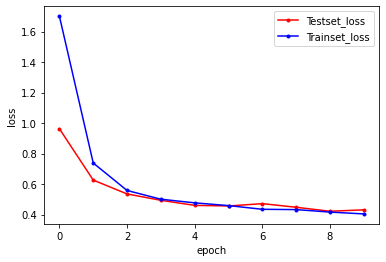

In [122]:
#학습에 사용할 train data 길이
train_length = 50000

#학습에 사용할 shape 정의
sp = 50 #shape

def RotateImage(img, angle, scale=1):
    if img.ndim > 2:
        height, width, channel = img.shape
    else:
        height, width = img.shape
 
    matrix = cv2.getRotationMatrix2D((width / 2, height / 2), angle, scale)
    result = cv2.warpAffine(img, matrix, (width, height))
 
    return result

pca_data = []
for j in tqdm(range(train_length)):
    img = cv2.imread("./dataset/Sparseimage/train/train_image{:0>5}.png".format(j), cv2.IMREAD_GRAYSCALE)
    pca_data.append(img)

tg = []        
for i in range(train_length):
    for _ in range(1):
        tg.append(train_df['label'][i])

target = np.array(tg)

#try cnn 2-2
data = np.array(pca_data)
# train_test_split
x_train, x_test, y_train, y_test = train_test_split(data, target, test_size=0.1, shuffle=True, stratify=target, random_state=34)
# x_test, x_valid, y_test, y_valid = train_test_split(x_valid, y_valid, test_size = 0.5, shuffle = True, stratify=y_valid, random_state=34)

row1 = x_train[0].shape[0]
col1 = x_train[0].shape[1]
input_shape = row1 * col1

x_train = x_train.reshape(-1, input_shape)
x_test = x_test.reshape(-1, input_shape)

# 각종 파라메터의 영향을 보기 위해 랜덤값 고정
tf.random.set_seed(1234)

# Normalizing data
x_train, x_test = x_train / 255.0, x_test / 255.0

# One-hot 인코딩
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

####################################################
# dnn modeling

model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(units=256, input_dim = input_shape, activation='relu'))
# model.add(tf.keras.layers.Dense(units=128, activation='relu'))
model.add(tf.keras.layers.Dense(units=64, activation='relu'))
# model.add(tf.keras.layers.Dense(units=32, activation='relu'))
model.add(tf.keras.layers.Dense(units=10, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer=tf.optimizers.Adam(lr=0.001), metrics=['accuracy'])
model.summary()

###################################################
#모델 최적화
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

modelpath = './dataset/model/imageSparse_CNN03.h5'
checkpointer = ModelCheckpoint(filepath = modelpath, monitor = 'val_loss', verbose = 1, save_best_only = True)
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 10)

#모델링 실행
history = model.fit(x_train, y_train, validation_split=0.2, epochs = 10, batch_size = 512, verbose=1, 
                    callbacks = [early_stopping_callback, checkpointer])


#테스트 정확도
print('\n Test Accuracy: {}'.format(round(model.evaluate(x_test, y_test)[1], 3)))

# 검증셋, 학습셋 오차 저장
y_vloss = history.history['val_loss']
y_loss = history.history['loss']

# 그래프로 표현
x_len = np.arange(len(y_loss))
plt.plot(x_len, y_vloss, marker='.', c='red', label='Testset_loss')
plt.plot(x_len, y_loss, marker='.', c='blue', label='Trainset_loss')


# 그래프에 그리드 부여 및 레이블 표시
plt.legend(loc = 'upper right')
# plt.gird()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [ ]:
##별도의 추가시도

In [2]:
import cv2
import numpy as np

img = cv2.imread("./dataset/pcaimage/train_image00000.jpg")
img = cv2.resize(img, (200,200))

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

blurring_mask1 = np.array([[1 / 9, 1 / 9, 1 / 9], [1 / 9, 1 / 9, 1 / 9], [1 / 9, 1 / 9, 1 / 9]])
blurring_mask2 = np.array([[1 / 25, 1 / 25, 1 / 25, 1 / 25, 1 / 25], [1 / 25, 1 / 25, 1 / 25, 1 / 25, 1 / 25],
                           [1 / 25, 1 / 25, 1 / 25, 1 / 25, 1 / 25], [1 / 25, 1 / 25, 1 / 25, 1 / 25, 1 / 25],
                           [1 / 25, 1 / 25, 1 / 25, 1 / 25, 1 / 25]])

smoothing_mask = np.array([[1 / 16, 1 / 8, 1 / 16], [1 / 8, 1 / 4, 1 / 8], [1 / 16, 1 / 8, 1 / 16]])

sharpening_mask1 = np.array([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]])
sharpening_mask2 = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])

blurring_out1 = cv2.filter2D(gray, -1, blurring_mask1)
blurring_out2 = cv2.filter2D(gray, -1, blurring_mask2)

smoothing_out = cv2.filter2D(gray, -1, smoothing_mask)

sharpening_out1 = cv2.filter2D(gray, -1, sharpening_mask1)
sharpening_out2 = cv2.filter2D(gray, -1, sharpening_mask2)

cv2.imshow("original", gray)

cv2.imshow('blurring(3X3)', blurring_out1)
cv2.imshow('blurring(5X5)', blurring_out2)

cv2.imshow('smoothing', smoothing_out)

cv2.imshow('sharpening1', sharpening_out1)
cv2.imshow('sharpening2', sharpening_out2)

cv2.waitKey(0)
cv2.destroyAllWindows()  

In [3]:
import cv2
import numpy as np

img = cv2.imread('./dataset/pcaimage/train_image00000.jpg')
img = cv2.resize(img, (100,100))
k = cv2.getStructuringElement(cv2.MORPH_RECT,(3,3))

erosion = cv2.erode(img, k)

cv2.imshow('erosion', erosion)
cv2.imshow('img', img)

# merged = np.hstack((img, erosion))
# cv2.imshow('Erode', merged)
cv2.waitKey(0)
cv2.destroyAllWindows()  

In [8]:
# 모폴로지 그레이언트 (morph_gradient.py)

import cv2
import numpy as np

img = cv2.imread('./dataset/pcaimage/train_image00005.jpg')

# 구조화 요소 커널, 사각형 (3x3) 생성 ---①
k = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
# 열림 연산 적용 ---②
gradient = cv2.morphologyEx(img, cv2.MORPH_GRADIENT, k)

# 결과 출력
merged = np.hstack((img, gradient))
cv2.imshow('gradient', merged)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [13]:
num = 3406

In [48]:
# 팽창 연산 (morph_dilate.py)

import cv2
import numpy as np




sharpening_mask1 = np.array([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]])
sharpening_mask2 = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])

smoothing_mask = np.array([[1 / 16, 1 / 8, 1 / 16], [1 / 8, 1 / 4, 1 / 8], [1 / 16, 1 / 8, 1 / 16]])

num += 1
img = cv2.imread('./dataset/Sparseimage/train/train_image{:0>5}.png'.format(num), cv2.IMREAD_GRAYSCALE)
print(train_df['label'][num])
img = cv2.resize(img, (200, 200))

# 구조화 요소 커널, 사각형 (3x3) 생성 ---①
k = cv2.getStructuringElement(cv2.MORPH_RECT, (11,11))
k2 = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))

# 팽창 연산 적용 ---②
dst = cv2.dilate(img, k)
dst = cv2.dilate(dst, k2)


#팽창 후 가우시안
gau = cv2.GaussianBlur(dst, (0, 0), 2)

#가우시안 후 샤프닝
sha1 = cv2.filter2D(gau, -1, sharpening_mask1)
# sharpening_out2 = cv2.filter2D(gray, -1, sharpening_mask2)

#가우시안 후 스무딩
smo1 = cv2.filter2D(gau, -1, smoothing_mask)

# 결과 출력
merged = np.hstack((img, dst))
cv2.imshow('Dilation', merged)
cv2.imshow('gaussian', gau)
cv2.imshow('sha1', sha1)
cv2.imshow('smo1', smo1)
cv2.waitKey(0)
cv2.destroyAllWindows()

8


In [59]:
# 팽창 연산 (morph_dilate.py)

import cv2
import numpy as np




sharpening_mask1 = np.array([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]])
sharpening_mask2 = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])

smoothing_mask = np.array([[1 / 16, 1 / 8, 1 / 16], [1 / 8, 1 / 4, 1 / 8], [1 / 16, 1 / 8, 1 / 16]])

num += 1
img = cv2.imread('./dataset/Sparseimage/train/train_image{:0>5}.png'.format(num), cv2.IMREAD_GRAYSCALE)
print(train_df['label'][num])

cv2.imshow('img1', img)
img = cv2.resize(img, (400, 400))

# 구조화 요소 커널, 사각형 (3x3) 생성 ---①
k = cv2.getStructuringElement(cv2.MORPH_RECT, (11,11))
k2 = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))

# 팽창 연산 적용 ---②
dst = cv2.dilate(img, k)
dst = cv2.dilate(dst, k2)


#팽창 후 가우시안
gau = cv2.GaussianBlur(dst, (0, 0), 2)

#가우시안 후 샤프닝
sha1 = cv2.filter2D(gau, -1, sharpening_mask1)
# sharpening_out2 = cv2.filter2D(gray, -1, sharpening_mask2)

#가우시안 후 스무딩
smo1 = cv2.filter2D(gau, -1, smoothing_mask)

sha1 = cv2.resize(sha1, (50, 50))

# 결과 출력
merged = np.hstack((img, dst))
cv2.imshow('Dilation', merged)
cv2.imshow('gaussian', gau)
cv2.imshow('sha1', sha1)
cv2.imshow('smo1', smo1)
cv2.waitKey(0)
cv2.destroyAllWindows()

4
